In [249]:
#Exploracion de los datos
import numpy as np
import pandas as pd
from datetime import datetime
#Visualizaciones
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
from IPython.display import display

In [251]:
# Carga dataset
store = pd.read_csv("C:/Users/aritz/Documents/UTP/Modelos Predictivos/Rossmann Store Sales/store.csv")


In [253]:
train = pd.read_csv("C:/Users/aritz/Documents/UTP/Modelos Predictivos/Rossmann Store Sales/train.csv",low_memory=False)

In [254]:
# nuevas features de fechas
train['Date'] = pd.to_datetime(train['Date'])

# Extrae las nuevas características de la columna 'Date'
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

In [255]:
# nueva variable ratios de ventas por clientes
train['SalePerCustomer'] = train['Sales']/train['Customers']

In [257]:
# Revisar si los null corresponde ha cuando la tienda esta cerrada 
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 14)

In [261]:
# No considerar datos de tienda cerrada y sales en cero
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

In total:  (844338, 14)


In [263]:
train=train.drop(columns=train[(train.Open == 1) & (train.Sales == 0)].index)

In [265]:
#verificar null de competition distance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.00,"2,013.00","Feb,May,Aug,Nov"


In [267]:
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median())

In [269]:
store.fillna(0, inplace = True)

In [271]:
# Unimos el dataset de ventas con la informacion por cada store
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

In [272]:
# dataset final:
print("Dataset Total: ", train_store.shape)

Dataset Total:  (844338, 23)


In [275]:
#Datos null
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
SalePerCustomer              0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [277]:
pd.options.display.float_format = '{:,.2f}'.format
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,"457,042.00","6,925.70","3,277.35",46.00,"4,695.25","6,285.00","8,406.00","41,551.00"
b,"15,560.00","10,233.38","5,155.73","1,252.00","6,345.75","9,130.00","13,184.25","38,722.00"
c,"112,968.00","6,933.13","2,896.96",133.00,"4,916.00","6,408.00","8,349.25","31,448.00"
d,"258,768.00","6,822.30","2,556.40",538.00,"5,050.00","6,395.00","8,123.25","38,037.00"


In [31]:
#df_final_train =  train_store[['Customers', 'Promo','Sales']]  

In [33]:
#df_export = df_final_train.to_csv('C:/Users/aritz/Documents/UTP/Modelos Predictivos/df_final_train.csv',index=None,sep=';')

In [79]:
#pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [35]:
#df_export = df_final_train.to_excel('C:/Users/aritz/Documents/UTP/Modelos Predictivos/df_final_train.xlsx')

In [37]:

#train_store['StateHoliday'] = train_store['StateHoliday'].replace({'a': 1, 'b': 2, 'c': 3, '0': 0}).astype(int)


In [279]:
df_final_train = train_store

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 3. Codificar columnas categóricas con LabelEncoder
label_cols = ['StoreType', 'Assortment', 'StateHoliday']
for col in label_cols:
    le = LabelEncoder()
    df_final_train[col] = le.fit_transform(df_final_train[col].astype(str))

# 4. Crear variables nuevas opcionales
#df_final_train['Customers_Promo2'] = df_final_train['Customers'] * df_final_train['Promo2']

# 5. Seleccionar variables predictoras (features)
features = [
    'DayOfWeek', 'Customers', 'Promo',
    'StoreType', 'Assortment', 'StateHoliday',
    'CompetitionDistance',
   # 'Customers_Promo2'
]

# 6. Variables objetivo
X = df_final_train[features]
y = df_final_train['Sales']

# 7. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Entrenar modelo XGBoost
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 9. Predicciones y evaluación
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²: {r2:.4f}")


XGBoost RMSE: 939.17
XGBoost R²: 0.9076


<Figure size 1000x800 with 0 Axes>

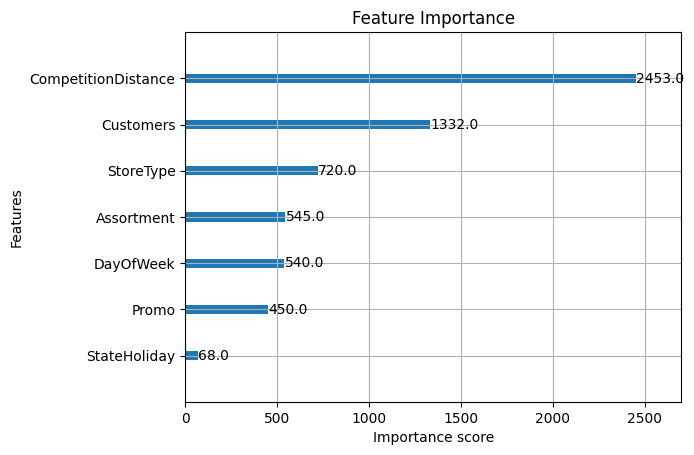

In [35]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Asumiendo que ya has entrenado el modelo XGBoost
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Mostrar la importancia de las características
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()


In [37]:
X.head(5)

,DayOfWeek,Customers,Promo,StoreType,Assortment,StateHoliday,CompetitionDistance
0,5,555,1,2,0,0,"1,270.00"
1,4,546,1,2,0,0,"1,270.00"
2,3,523,1,2,0,0,"1,270.00"
3,2,560,1,2,0,0,"1,270.00"
4,1,612,1,2,0,0,"1,270.00"


In [45]:


  # Suponiendo que 'y_test' son los valores reales y 'y_pred' las predicciones del modelo
  residuos = y_test - y_pred


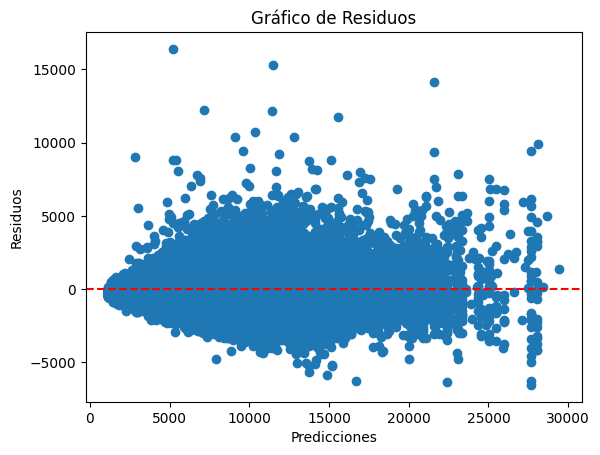

In [47]:
  import matplotlib.pyplot as plt

  plt.scatter(y_pred, residuos)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Predicciones')
  plt.ylabel('Residuos')
  plt.title('Gráfico de Residuos')
  plt.show()


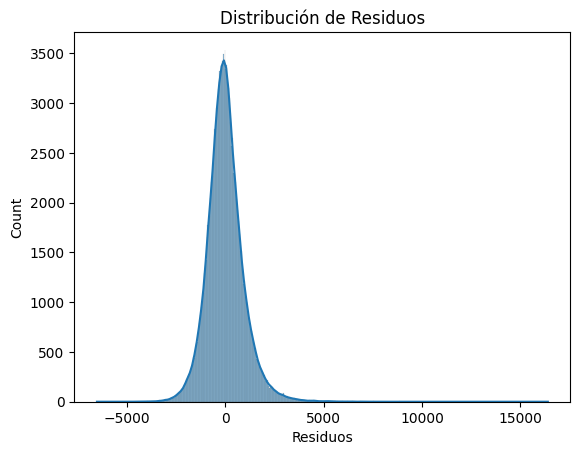

In [49]:
  import seaborn as sns

  sns.histplot(residuos, kde=True)
  plt.xlabel('Residuos')
  plt.title('Distribución de Residuos')
  plt.show()


In [139]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


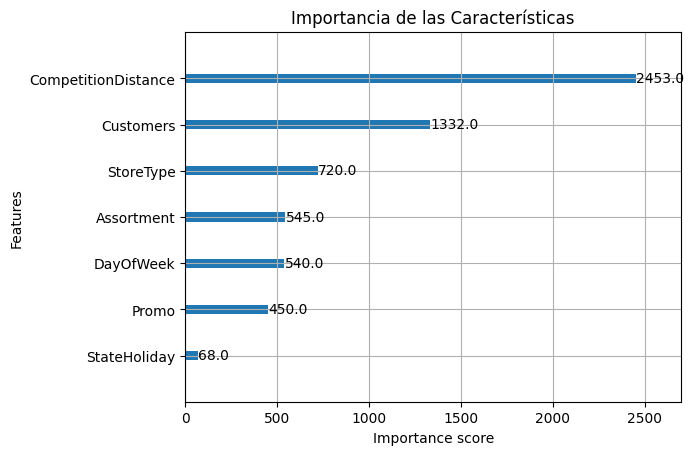

In [141]:
# Usa la función  para entender cuáles variables tienen mayor peso en las predicciones
from xgboost import plot_importance
plot_importance(model)
plt.title("Importancia de las Características")
plt.show()

In [145]:
#Para una evaluación más robusta, podrías implementar una validación cruzada:
import xgboost as xgb

# Crear un objeto DMatrix con las características y la variable objetivo
dtrain = xgb.DMatrix(X_train, label=y_train)

# Definir los parámetros del modelo
params = {
    'objective': 'reg:squarederror',  # Tipo de problema: regresión
    'learning_rate': 0.1,            # Tasa de aprendizaje
    'max_depth': 6,                  # Profundidad máxima de los árboles
    'seed': 42                       # Para reproducibilidad
}

# Realizar la validación cruzada
results = xgb.cv(
    params=params, 
    dtrain=dtrain, 
    nfold=5,               # Número de pliegues de validación cruzada
    num_boost_round=100,   # Número de iteraciones (árboles)
    metrics='rmse',        # Métrica de evaluación
    as_pandas=True,        # Devolver resultados como un DataFrame de pandas
    seed=42                # Semilla para reproducibilidad
)

# Mostrar los resultados de la validación cruzada
print(results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          2,855.83            2.29        2,855.95           9.54
1          2,632.74            1.92        2,632.97           9.10
2          2,435.06            1.26        2,435.44           9.07
3          2,260.15            1.65        2,260.73           8.22
4          2,105.71            2.05        2,106.37           7.04
..              ...             ...             ...            ...
95           934.61            2.00          939.88           3.61
96           933.08            2.12          938.39           3.63
97           932.06            1.97          937.42           4.05
98           930.74            2.27          936.07           4.14
99           928.64            2.62          934.01           3.41

[100 rows x 4 columns]


In [281]:
# Ordenar el DataFrame por la columna 'fecha' en orden ascendente
df_final_train = df_final_train.sort_values(by='Date', ascending=True)

# Restablecer los índices después de ordenar
df_final_train = df_final_train.reset_index(drop=True)

In [283]:
from sklearn.preprocessing import LabelEncoder
# 3. Codificar columnas categóricas con LabelEncoder
label_cols = ['StoreType', 'Assortment', 'StateHoliday']
for col in label_cols:
    le = LabelEncoder()
    df_final_train[col] = le.fit_transform(df_final_train[col].astype(str))

In [285]:
# DF MES JUL 2015 para validar el modelo con datos reales
df_julio_2015 = (df_final_train['Date'].dt.year == 2015) & (df_final_train['Date'].dt.month == 7)
dataset_julio_2015 =  df_final_train[df_julio_2015]

In [287]:
# Convierte la columna 'Date' al tipo datetime si no lo está
df_final_train['Date'] = pd.to_datetime(df_final_train['Date'])

df_sin_julio2015 = ~((df_final_train['Date'].dt.year == 2015) & (df_final_train['Date'].dt.month == 7))

# DataFrame sin julio de 2015
dataset_train = df_final_train[df_sin_julio2015]


In [291]:
# Validacion de los dataset
fecha_minima = dataset_train['Date'].min()
fecha_maxima = dataset_train['Date'].max()

print(f'Fecha mínima: {fecha_minima}')
print(f'Fecha máxima: {fecha_maxima}')

Fecha mínima: 2013-01-01 00:00:00
Fecha máxima: 2015-06-30 00:00:00


In [293]:
dataset_julio_2015.head(6)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
814150,1015,3,2015-07-01,7434,527,1,1,0,0,2015,...,14.11,3,2,"9,910.00",12.00,"2,010.00",1,9.00,"2,011.00","Mar,Jun,Sept,Dec"
814151,952,3,2015-07-01,5613,459,1,1,0,0,2015,...,12.23,3,2,"6,300.00",10.00,"2,013.00",0,0.00,0.00,0
814152,553,3,2015-07-01,6523,560,1,1,0,0,2015,...,11.65,2,0,"3,040.00",9.00,"2,002.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct"
814153,828,3,2015-07-01,6277,658,1,1,0,0,2015,...,9.54,3,2,"3,290.00",12.00,"2,014.00",0,0.00,0.00,0
814154,203,3,2015-07-01,9592,1168,1,1,0,0,2015,...,8.21,2,2,490.00,11.00,"2,002.00",0,0.00,0.00,0
814155,943,3,2015-07-01,7868,619,1,1,0,1,2015,...,12.71,3,2,"18,020.00",0.00,0.00,0,0.00,0.00,0


In [295]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


# 4. Crear variables nuevas opcionales
#df_final_train['Customers_Promo2'] = df_final_train['Customers'] * df_final_train['Promo2']

# 5. Seleccionar variables predictoras (features)
features = [
    'DayOfWeek', 'Customers', 'Promo',
    'StoreType', 'Assortment', 'StateHoliday',
    'CompetitionDistance',
]

# 6. Variables objetivo
X = dataset_train[features]
y = dataset_train['Sales']

# 7. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [297]:

# Entrenar el modelo con el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"XGBoost (Optimizado) RMSE: {rmse:.2f}")
print(f"XGBoost (Optimizado) R²: {r2:.4f}")



XGBoost (Optimizado) RMSE: 661.92
XGBoost (Optimizado) R²: 0.9546


In [326]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
# Crear el modelo con los parámetros optimizados
best_model = XGBRegressor(
    learning_rate=0.2,
    max_depth=8,
    reg_alpha=0.01,#nuevo
    reg_lambda=1.0,#nuevo
    n_estimators=200,
    subsample=0.8, #nuevos
    colsample_bytree = 0.8, #nuevos
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
r2 = r2_score(y_test, y_pred)                      # R²
mae = mean_absolute_error(y_test, y_pred)          # MAE
mape = np.mean(abs((y_test - y_pred) / y_test)) * 100  # MAPE
mad = np.mean(abs(y_test - y_pred))                # MAD

# Imprimir todas las métricas
print(f"XGBoost (Optimizado) RMSE: {rmse:.2f}")
print(f"XGBoost (Optimizado) R²: {r2:.4f}")
print(f"XGBoost (Optimizado) MAE: {mae:.2f}")
print(f"XGBoost (Optimizado) MAPE: {mape:.2f}%")
print(f"XGBoost (Optimizado) MAD: {mad:.2f}")

XGBoost (Optimizado) RMSE: 690.32
XGBoost (Optimizado) R²: 0.9506
XGBoost (Optimizado) MAE: 481.61
XGBoost (Optimizado) MAPE: 7.21%
XGBoost (Optimizado) MAD: 481.61


XGBoost (Optimizado) RMSE: 661.92
XGBoost (Optimizado) R²: 0.9546
XGBoost (Optimizado) MAE: 455.22
XGBoost (Optimizado) MAPE: 6.77%
XGBoost (Optimizado) MAD: 455.22

In [321]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
# Crear el modelo con los parámetros optimizados
best_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=300,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
r2 = r2_score(y_test, y_pred)                      # R²
mae = mean_absolute_error(y_test, y_pred)          # MAE
mape = np.mean(abs((y_test - y_pred) / y_test)) * 100  # MAPE
mad = np.mean(abs(y_test - y_pred))                # MAD

# Imprimir todas las métricas
print(f"XGBoost (Optimizado) RMSE: {rmse:.2f}")
print(f"XGBoost (Optimizado) R²: {r2:.4f}")
print(f"XGBoost (Optimizado) MAE: {mae:.2f}")
print(f"XGBoost (Optimizado) MAPE: {mape:.2f}%")
print(f"XGBoost (Optimizado) MAD: {mad:.2f}")

XGBoost (Optimizado) RMSE: 710.34
XGBoost (Optimizado) R²: 0.9477
XGBoost (Optimizado) MAE: 500.31
XGBoost (Optimizado) MAPE: 7.48%
XGBoost (Optimizado) MAD: 500.31


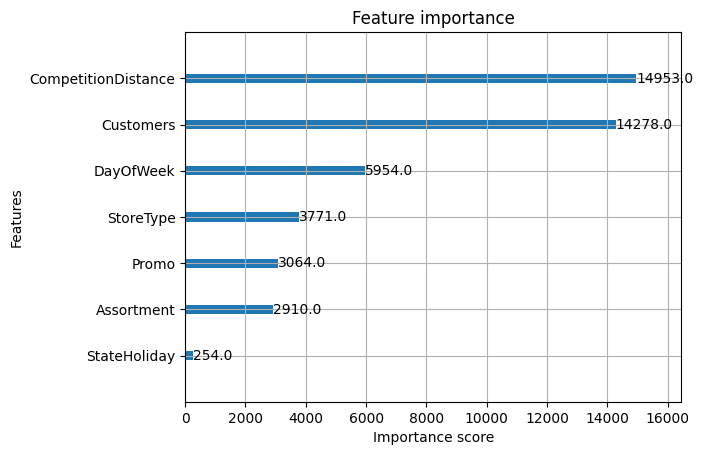

In [299]:
from xgboost import plot_importance
plot_importance(best_model)
plt.show()

In [301]:
#Para una evaluación más robusta, podrías implementar una validación cruzada:
import xgboost as xgb

# Crear un objeto DMatrix con las características y la variable objetivo
dtrain = xgb.DMatrix(X_train, label=y_train)

# Definir los parámetros del modelo
params = {
    'objective': 'reg:squarederror',  # Tipo de problema: regresión
    'learning_rate': 0.2,            # Tasa de aprendizaje
    'max_depth': 8 ,                 # Profundidad máxima de los árboles
    'seed': 42                       # Para reproducibilidad
}

# Realizar la validación cruzada
results = xgb.cv(
    params=params, 
    dtrain=dtrain, 
    nfold=10,               # Número de pliegues de validación cruzada
    num_boost_round=200,   # Número de iteraciones (árboles)
    metrics='rmse',        # Métrica de evaluación
    as_pandas=True,        # Devolver resultados como un DataFrame de pandas
    seed=42                # Semilla para reproducibilidad
)

# Mostrar los resultados de la validación cruzada
print(results)

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           2,589.34            1.51        2,589.80          13.42
1           2,186.18            1.41        2,187.49          11.03
2           1,878.49            1.05        1,880.48           9.40
3           1,646.57            1.34        1,649.74           8.04
4           1,472.65            2.28        1,476.60           6.26
..               ...             ...             ...            ...
195           635.66            3.05          668.59           8.07
196           635.38            3.05          668.37           8.02
197           635.05            3.03          668.15           8.04
198           634.80            2.97          667.99           8.01
199           634.44            2.95          667.78           8.00

[200 rows x 4 columns]


In [307]:
# Predicciones en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)

# Evaluar las métricas en el conjunto de entrenamiento

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = np.mean(abs((y_train - y_train_pred) / y_train)) * 100
mad_train = np.mean(abs(y_train - y_train_pred))

# Imprimir resultados
print(f"RMSE de Entrenamiento: {rmse_train:.2f}")
print(f"R² de Entrenamiento: {r2_train:.4f}")
print(f"MAE de Entrenamiento: {mae_train:.2f}")
print(f"MAPE de Entrenamiento: {mape_train:.2f}%")
print(f"MAD de Entrenamiento: {mad_train:.2f}")


RMSE de Entrenamiento: 637.37
R² de Entrenamiento: 0.9580
MAE de Entrenamiento: 441.77
MAPE de Entrenamiento: 6.60%
MAD de Entrenamiento: 441.77


In [238]:
#df_export_results = results.to_excel('C:/Users/aritz/Documents/UTP/Modelos Predictivos/result_validacion_cruzada.xlsx')

In [155]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 3. Codificar columnas categóricas con LabelEncoder
#label_cols = ['StoreType', 'Assortment', 'StateHoliday']
#for col in label_cols:
   # le = LabelEncoder()
   # df_final_train[col] = le.fit_transform(df_final_train[col].astype(str))

# 4. Crear variables nuevas opcionales
#df_final_train['Customers_Promo2'] = df_final_train['Customers'] * df_final_train['Promo2']

# 5. Seleccionar variables predictoras (features)
features = [ 'Customers', 'Promo']

# 6. Variables objetivo
X = df_final_train[features]
y = df_final_train['Sales']

# 7. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Entrenar modelo XGBoost
model = XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.21, random_state=42)
model.fit(X_train, y_train)

# 9. Predicciones y evaluación
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²: {r2:.4f}")


XGBoost RMSE: 1551.38
XGBoost R²: 0.7479


In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Seleccionar las mismas características utilizadas en el entrenamiento
features = [
    'DayOfWeek', 'Customers', 'Promo',
    'StoreType', 'Assortment', 'StateHoliday',
    'CompetitionDistance'
]

# Separar las características y la variable objetivo
X_julio = dataset_julio_2015[features]
y_julio = dataset_julio_2015['Sales']

# Realizar predicciones con el modelo entrenado
y_pred_julio = best_model.predict(X_julio)

# Calcular métricas de evaluación
rmse_julio = np.sqrt(mean_squared_error(y_julio, y_pred_julio))
r2_julio = r2_score(y_julio, y_pred_julio)
mae_julio = mean_absolute_error(y_julio, y_pred_julio)
print(f"XGBoost RMSE en julio 2015: {rmse_julio:.2f}")
print(f"XGBoost R² en julio 2015: {r2_julio:.4f}")
print(f"MAE para julio 2015: {mae_julio:.2f}")

XGBoost RMSE en julio 2015: 734.70
XGBoost R² en julio 2015: 0.9374
MAE para julio 2015: 527.63


In [305]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Seleccionar las mismas características utilizadas en el entrenamiento
features = [
    'DayOfWeek', 'Customers', 'Promo',
    'StoreType', 'Assortment', 'StateHoliday',
    'CompetitionDistance'
]

# Separar las características y la variable objetivo
X_julio = dataset_julio_2015[features]
y_julio = dataset_julio_2015['Sales']

# Realizar predicciones con el modelo entrenado
y_pred_julio = best_model.predict(X_julio)

# Calcular métricas de evaluación
rmse_julio = np.sqrt(mean_squared_error(y_julio, y_pred_julio))
r2_julio = r2_score(y_julio, y_pred_julio)
mae_julio = mean_absolute_error(y_julio, y_pred_julio)
mape_julio = np.mean(abs((y_julio - y_pred_julio) / y_julio)) * 100
mad_julio = np.mean(abs(y_julio - y_pred_julio))

# Imprimir resultados
print(f"XGBoost RMSE en julio 2015: {rmse_julio:.2f}")
print(f"XGBoost R² en julio 2015: {r2_julio:.4f}")
print(f"MAE para julio 2015: {mae_julio:.2f}")
print(f"MAPE para julio 2015: {mape_julio:.2f}%")
print(f"MAD para julio 2015: {mad_julio:.2f}")

XGBoost RMSE en julio 2015: 734.70
XGBoost R² en julio 2015: 0.9374
MAE para julio 2015: 527.63
MAPE para julio 2015: 7.40%
MAD para julio 2015: 527.63


In [133]:

# Suponiendo que 'y_julio' contiene los valores reales y 'y_pred_julio' las predicciones
comparacion = pd.DataFrame({'Real': y_julio, 'Predicción': y_pred_julio})

# Opcional: añadir una columna con la diferencia absoluta entre los valores reales y las predicciones
comparacion['Diferencia'] = abs(comparacion['Real'] - comparacion['Predicción'])

# Mostrar las primeras filas del DataFrame de comparación
print(comparacion.head())


        Real  Predicción  Diferencia
814150  7434    6,586.00      848.00
814151  5613    5,839.81      226.81
814152  6523    6,280.24      242.76
814153  6277    6,601.66      324.66
814154  9592    9,920.95      328.95


In [139]:
# df_export_comparacion = comparacion.to_excel('C:/Users/aritz/Documents/UTP/Modelos Predictivos/compar_real_pred.xlsx')

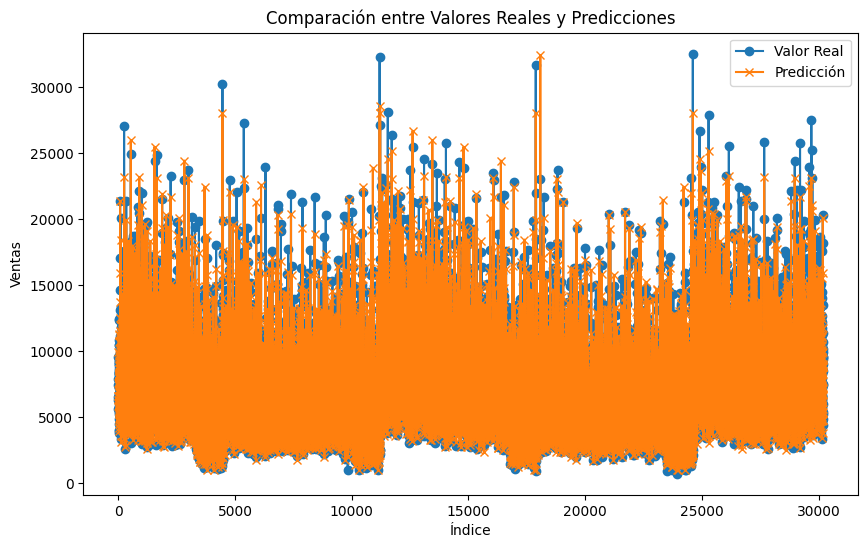

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(comparacion['Real'].values, label='Valor Real', marker='o')
plt.plot(comparacion['Predicción'].values, label='Predicción', marker='x')
plt.xlabel('Índice')
plt.ylabel('Ventas')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.legend()
plt.show()


In [187]:
data_test_prod_ago15 = pd.read_excel("C:/Users/aritz/Documents/UTP/Modelos Predictivos/data_test_prod_ago15.xlsx")

In [197]:
# DF MES JUL 2015 para validar el modelo con datos reales
df_ago_2014 = (df_final_train['Date'].dt.year == 2014) & (df_final_train['Date'].dt.month == 8)
dataset_ago_14 =  df_final_train[df_ago_2014]

In [203]:
dataset_ago_14.count()

Store                        24388
DayOfWeek                    24388
Date                         24388
Sales                        24388
Customers                    24388
Open                         24388
Promo                        24388
StateHoliday                 24388
SchoolHoliday                24388
Year                         24388
Month                        24388
Day                          24388
WeekOfYear                   24388
SalePerCustomer              24388
StoreType                    24388
Assortment                   24388
CompetitionDistance          24388
CompetitionOpenSinceMonth    24388
CompetitionOpenSinceYear     24388
Promo2                       24388
Promo2SinceWeek              24388
Promo2SinceYear              24388
PromoInterval                24388
dtype: int64

In [229]:
# Calcular promedio de ventas por tienda
promedio_por_tienda = dataset_ago_14.groupby('Store')['Customers'].mean().reset_index()
# promedio_por_tienda.rename(columns={'Customers': 'Promedio_Customers'}, inplace=True)
promedio_por_tienda['Customers'] = promedio_por_tienda['Customers'].round().astype(int)
# Visualizar el resultado
print(promedio_por_tienda.head())

   Store  Customers
0      1        503
1      2        560
2      3        707
3      4       1323
4      5        505


In [231]:
# Unimos el dataset de ventas con la informacion por cada store
dataset_ago15_with_customers = pd.merge(data_test_prod_ago15, promedio_por_tienda, how = 'inner', on = 'Store')

In [233]:
# Ordenar el DataFrame por la columna 'fecha' en orden ascendente
dataset_ago15_with_customers = dataset_ago15_with_customers.sort_values(by='Date', ascending=True)

# Restablecer los índices después de ordenar
dataset_ago15_with_customers = dataset_ago15_with_customers.reset_index(drop=True)

In [235]:
dataset_ago15_with_customers.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Assortment,StoreType,CompetitionDistance,Customers
0,40660,553,6,2015-08-01,1,0,0,0,a,c,3040,646
1,40538,398,6,2015-08-01,1,0,0,0,c,c,1540,636
2,40537,397,6,2015-08-01,1,0,0,0,c,a,130,737
3,40536,395,6,2015-08-01,1,0,0,0,a,a,3620,493
4,40535,394,6,2015-08-01,1,0,0,1,a,d,10850,617


In [241]:
from sklearn.preprocessing import LabelEncoder
# 3. Codificar columnas categóricas con LabelEncoder
label_cols = ['StoreType', 'Assortment', 'StateHoliday']
for col in label_cols:
    le = LabelEncoder()
    dataset_ago15_with_customers[col] = le.fit_transform(dataset_ago15_with_customers[col].astype(str))

In [247]:
# Seleccionar las características para el modelo
features = [
    'DayOfWeek', 'Customers', 'Promo',
    'StoreType', 'Assortment', 'StateHoliday',
    'CompetitionDistance'
]
X_agosto = dataset_ago15_with_customers[features]

# Realizar predicciones
ventas_predichas = best_model.predict(X_agosto)

# Agregar predicciones al DataFrame de agosto
dataset_ago15_with_customers['Ventas Predichas'] = ventas_predichas

# Visualizar resultados
print(datos_agosto.head())

      Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  \
0  40660    553          6 2015-08-01     1      0             0   
1  40538    398          6 2015-08-01     1      0             0   
2  40537    397          6 2015-08-01     1      0             0   
3  40536    395          6 2015-08-01     1      0             0   
4  40535    394          6 2015-08-01     1      0             0   

   SchoolHoliday  Assortment  StoreType  CompetitionDistance  Customers  \
0              0           0          2                 3040        646   
1              0           2          2                 1540        636   
2              0           2          0                  130        737   
3              0           0          0                 3620        493   
4              1           0          3                10850        617   

   Ventas Predichas  
0          6,788.83  
1          5,489.72  
2          5,526.95  
3          4,111.79  
4          7,498.24  


In [ ]:
# Calcular métricas de rendimiento
rmse = np.sqrt(mean_squared_error(dataset_ago15_with_customers['Ventas Reales'], dataset_ago15_with_customers['Ventas Predichas']))
r2 = r2_score(dataset_ago15_with_customers['Ventas Reales'], dataset_ago15_with_customers['Ventas Predichas'])
mae = mean_absolute_error(datos_agosto['Ventas Reales'], datos_agosto['Ventas Predichas'])
mape = np.mean(abs((datos_agosto['Ventas Reales'] - datos_agosto['Ventas Predichas']) / datos_agosto['Ventas Reales'])) * 100
mad = np.mean(abs(datos_agosto['Ventas Reales'] - datos_agosto['Ventas Predichas']))

# Mostrar métricas
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAD: {mad:.2f}")

In [326]:

# Calcular la matriz de correlación
matriz_correlacion = df_numerico.corr()

print(matriz_correlacion)


                           Store  DayOfWeek  Sales  Customers  Promo  \
Store                       1.00       0.00   0.01       0.03  -0.00   
DayOfWeek                   0.00       1.00  -0.18      -0.10  -0.29   
Sales                       0.01      -0.18   1.00       0.82   0.37   
Customers                   0.03      -0.10   0.82       1.00   0.18   
Promo                      -0.00      -0.29   0.37       0.18   1.00   
StateHoliday                0.00      -0.00   0.02       0.05  -0.00   
SchoolHoliday              -0.00      -0.14   0.03       0.02   0.02   
Year                        0.00       0.00   0.04       0.00   0.02   
Month                       0.00      -0.02   0.07       0.06  -0.01   
Day                        -0.00       0.01  -0.06      -0.04  -0.14   
WeekOfYear                  0.00      -0.01   0.08       0.06   0.01   
SalePerCustomer            -0.05      -0.10   0.19      -0.32   0.28   
StoreType                  -0.02      -0.00  -0.02      -0.20   

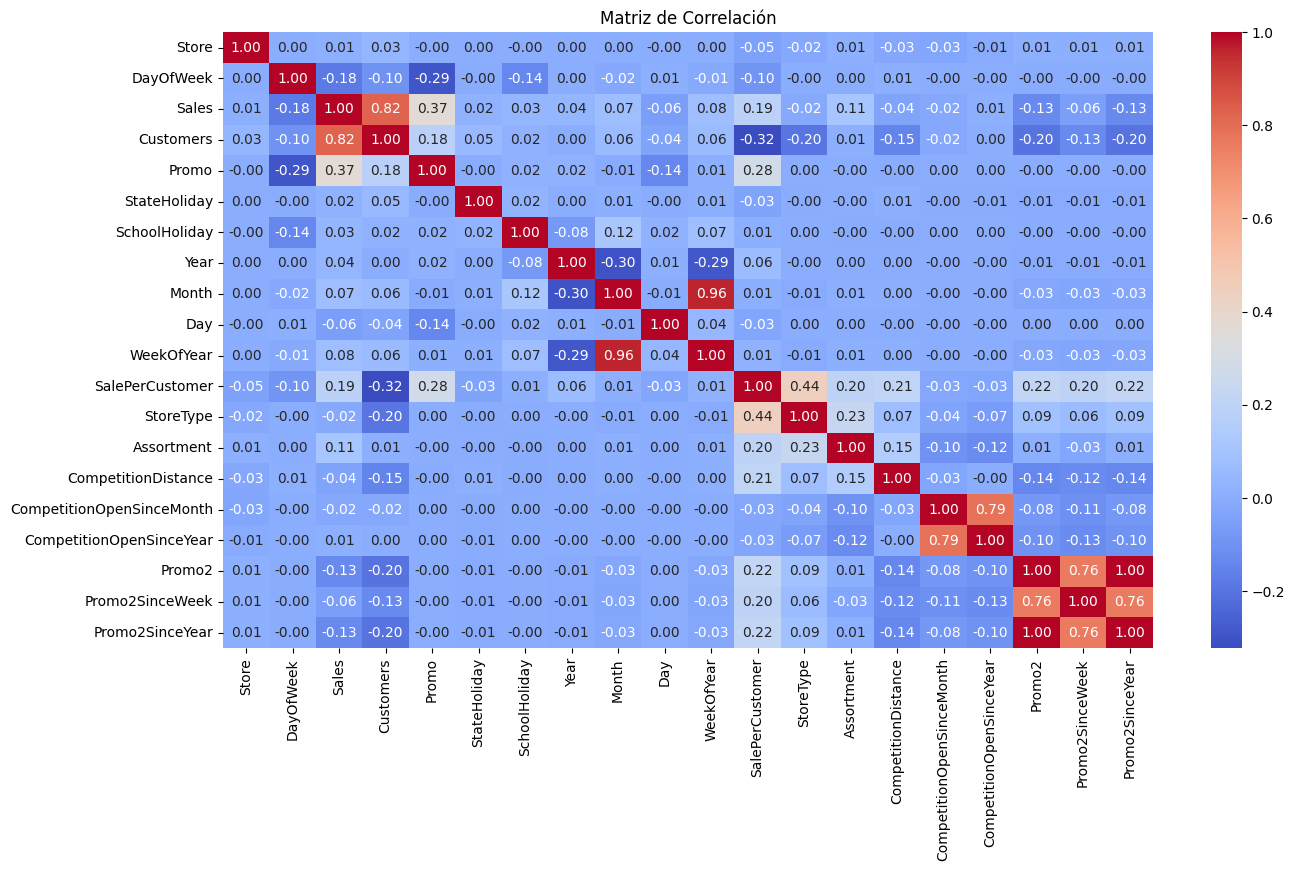

In [328]:

# Crear el mapa de calor
plt.figure(figsize=(15,8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()
